In [1]:
import numpy as np

In [2]:
detector_array = np.zeros((500, 500))
print(detector_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
pixel_edge_length = 15 #microns
pixel_half_length = (pixel_edge_length / 2)
num_of_pixels = 500
num_of_pixel_x = 500
num_of_pixel_y = 500
electrons_per_photon = 1500 #electrons

In [4]:
def bottom_left_of_pixel():
    pixel_corner_i = i * pixel_edge_length
    pixel_corner_j = j * pixel_edge_length

In [5]:
#i = the row value of pixel
#j = the column value of pixel
#horz_d= horizontal distance from bottom left
#vert_d= vertical distance from bottom left
def center_of_pixel(pixel_edge_length, i, j):
    horz_d = (i * pixel_edge_length) + pixel_half_length
    vert_d = (j * pixel_edge_length) + pixel_half_length
    #print("pixel: [" + str(i) + ", " + str(j) + "], center of pixel: [" + str(horz_d) + ", " + str(vert_d) + "] microns.")
for i in range(len(detector_array)):
    for j in range(len(detector_array)):
        center_of_pixel(pixel_edge_length, i, j)   

In [6]:
import random
#the random.random() makes a random number between 0 & 1, so we multiply it to get the range we want
photon_sphere_x = random.random() * pixel_edge_length * num_of_pixel_x #microns
photon_sphere_y = random.random() * pixel_edge_length * num_of_pixel_y #microns
photon_sphere_z = 15 #microns
print("photon hit at [x,y] = [" + str(photon_sphere_x) + ", " + str(photon_sphere_y) + "] microns")

photon hit at [x,y] = [3219.8729531987474, 3467.6437304062074] microns


In [7]:
#photon_sphere_x and photon_sphere_y is the center point of the sphere
diameter_electron_cloud = 10 #microns
radius_electron_cloud = diameter_electron_cloud / 2 #microns

In [9]:
detector_array_x = np.arange(num_of_pixel_x) * pixel_edge_length + pixel_half_length
detector_array_y = np.arange(num_of_pixel_y) * pixel_edge_length + pixel_half_length
#remember multiple pixels have the same center value, but this array contains all of those possibilities

In [11]:
#redefining variables as arrays to be more precise
photon_sphere_microns = [photon_sphere_x, photon_sphere_y, photon_sphere_z]
photon_sphere_pixel = [photon_sphere_x / pixel_edge_length, photon_sphere_y / pixel_edge_length]
print("sphere position  in microns " + str(photon_sphere_microns))
print("sphere position in pixel " + str(photon_sphere_pixel))


sphere position  in microns [3219.8729531987474, 3467.6437304062074, 15]
sphere position in pixel [214.6581968799165, 231.17624869374717]


In [12]:
closest_pixel_x = (np.where(np.abs(detector_array_x - photon_sphere_x) == np.min(np.abs(detector_array_x - photon_sphere_x))))[0]
closest_pixel_x_microns = closest_pixel_x [0] * pixel_edge_length + pixel_half_length
closest_pixel_y = (np.where(np.abs(detector_array_y - photon_sphere_y) == np.min(np.abs(detector_array_y - photon_sphere_y))))[0]
closest_pixel_y_microns = closest_pixel_y [0] * pixel_edge_length + pixel_half_length
closest_pixel_arr = [closest_pixel_x[0], closest_pixel_y[0]]
closest_pixel_microns = [closest_pixel_x_microns, closest_pixel_y_microns]
print("closest pixel to sphere: " + str(closest_pixel_arr))
print("closest pixel's center in microns: " + str(closest_pixel_microns))

closest pixel to sphere: [214, 231]
closest pixel's center in microns: [3217.5, 3472.5]


In [13]:
#measure the distance from closest_pixel_microns to photon_sphere_microns in x and y directions
#all variables here are measured in microns
dist_sphere_pixel_x = np.abs(closest_pixel_x_microns - photon_sphere_x)
dist_sphere_pixel_y = np.abs(closest_pixel_y_microns - photon_sphere_y)
total_dist_sphere_pixel = np.sqrt((dist_sphere_pixel_x ** 2) + (dist_sphere_pixel_y ** 2))
print("distnace in x: " + str(dist_sphere_pixel_x) + " microns, " + "distance in y: " + str(dist_sphere_pixel_y) + " microns")
print("total distance from center of sphere to center of pixel: " + str(total_dist_sphere_pixel) + " microns")

distnace in x: 2.372953198747382 microns, distance in y: 4.856269593792604 microns
total distance from center of sphere to center of pixel: 5.405021854816131 microns


In [14]:
#use distance values and write a if, ifelse etc statement to solve for when the circle is:
#contained within the pixel, intersected by one line (in y or x), or  intersected by 2 lines (in y and x)
electrons_per_photon = 1500 #electrons
max_dist_from_center = (pixel_edge_length - diameter_electron_cloud) / 2
if (dist_sphere_pixel_x < max_dist_from_center and dist_sphere_pixel_y < max_dist_from_center):
    print('photon contained within pixel ' + str(closest_pixel_arr))
    detector_array [closest_pixel_x, closest_pixel_y] = electrons_per_photon
elif (dist_sphere_pixel_x >= max_dist_from_center and dist_sphere_pixel_y < max_dist_from_center):
    print('photon bisected by vertical line')
#vertical line means we need to use the x distance to find the are or % of sphere that spills into next pixel
elif (dist_sphere_pixel_y >= max_dist_from_center and dist_sphere_pixel_x < max_dist_from_center):
    print('photon bisected by horizontal line')
else (dist_sphere_pixel_y >= max_dist_from_center and dist_sphere_pixel_x >= max_dist_from_center):
    
    


SyntaxError: invalid syntax (<ipython-input-14-0b766b217fa3>, line 13)

In [15]:
sm_pixel_edge_length = .5 #microns
sm_pixel_half_length = sm_pixel_edge_length/2 #microns
sm_num_of_pixels = 90
sm_third_pixels = sm_num_of_pixels / 3
sm_two_thirds_pixels = sm_num_of_pixels * (2/3)
sm_array = np.zeros ((sm_num_of_pixels, sm_num_of_pixels, sm_num_of_pixels))
sm_x_cen = np.arange(sm_num_of_pixels) * sm_pixel_edge_length + (detector_array_x[closest_pixel_x] - pixel_half_length) + sm_pixel_edge_length
sm_y_cen = np.arange(sm_num_of_pixels) * sm_pixel_edge_length + (detector_array_y[closest_pixel_y] - pixel_half_length) + sm_pixel_edge_length   

In [16]:
sm_x_cen

array([3210.5, 3211. , 3211.5, 3212. , 3212.5, 3213. , 3213.5, 3214. ,
       3214.5, 3215. , 3215.5, 3216. , 3216.5, 3217. , 3217.5, 3218. ,
       3218.5, 3219. , 3219.5, 3220. , 3220.5, 3221. , 3221.5, 3222. ,
       3222.5, 3223. , 3223.5, 3224. , 3224.5, 3225. , 3225.5, 3226. ,
       3226.5, 3227. , 3227.5, 3228. , 3228.5, 3229. , 3229.5, 3230. ,
       3230.5, 3231. , 3231.5, 3232. , 3232.5, 3233. , 3233.5, 3234. ,
       3234.5, 3235. , 3235.5, 3236. , 3236.5, 3237. , 3237.5, 3238. ,
       3238.5, 3239. , 3239.5, 3240. , 3240.5, 3241. , 3241.5, 3242. ,
       3242.5, 3243. , 3243.5, 3244. , 3244.5, 3245. , 3245.5, 3246. ,
       3246.5, 3247. , 3247.5, 3248. , 3248.5, 3249. , 3249.5, 3250. ,
       3250.5, 3251. , 3251.5, 3252. , 3252.5, 3253. , 3253.5, 3254. ,
       3254.5, 3255. ])

In [17]:
detector_array_x[closest_pixel_x]

array([3217.5])

In [18]:
sm_y_cen

array([3465.5, 3466. , 3466.5, 3467. , 3467.5, 3468. , 3468.5, 3469. ,
       3469.5, 3470. , 3470.5, 3471. , 3471.5, 3472. , 3472.5, 3473. ,
       3473.5, 3474. , 3474.5, 3475. , 3475.5, 3476. , 3476.5, 3477. ,
       3477.5, 3478. , 3478.5, 3479. , 3479.5, 3480. , 3480.5, 3481. ,
       3481.5, 3482. , 3482.5, 3483. , 3483.5, 3484. , 3484.5, 3485. ,
       3485.5, 3486. , 3486.5, 3487. , 3487.5, 3488. , 3488.5, 3489. ,
       3489.5, 3490. , 3490.5, 3491. , 3491.5, 3492. , 3492.5, 3493. ,
       3493.5, 3494. , 3494.5, 3495. , 3495.5, 3496. , 3496.5, 3497. ,
       3497.5, 3498. , 3498.5, 3499. , 3499.5, 3500. , 3500.5, 3501. ,
       3501.5, 3502. , 3502.5, 3503. , 3503.5, 3504. , 3504.5, 3505. ,
       3505.5, 3506. , 3506.5, 3507. , 3507.5, 3508. , 3508.5, 3509. ,
       3509.5, 3510. ])

In [19]:
sm_z_cen = np.arange(sm_num_of_pixels) * sm_pixel_edge_length

In [20]:
for i in range(sm_num_of_pixels):
    for j in range(sm_num_of_pixels):
        for k in range(sm_num_of_pixels):
            distance_to_center_of_photon = np.sqrt((sm_x_cen[i]-photon_sphere_x)**2 + \
                                                (sm_y_cen[j]-photon_sphere_y)**2 + \
                                                (sm_z_cen[k]-photon_sphere_z)**2)
            if distance_to_center_of_photon < diameter_electron_cloud/2:
                sm_array[i,j,k] = 1.

In [21]:
%matplotlib inline

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

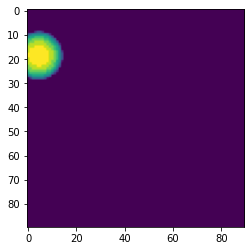

In [23]:
img = np.sum(sm_array,axis=2)
imgplot = plt.imshow(img)

In [24]:
np.sum(img)

3489.0

In [25]:
percent_pixel_1 = np.sum(img[0:int(sm_third_pixels), 0:int(sm_third_pixels)]) / np.sum(img)
percent_pixel_2 = np.sum(img[0:int(sm_third_pixels), int(sm_third_pixels):int(sm_two_thirds_pixels)]) / np.sum(img)
percent_pixel_3 = np.sum(img[0:int(sm_third_pixels), int(sm_two_thirds_pixels):int(sm_num_of_pixels)]) / np.sum(img)
percent_pixel_4 = np.sum(img[int(sm_third_pixels):int(sm_two_thirds_pixels), 0:int(sm_third_pixels)]) / np.sum(img)
percent_pixel_5 = np.sum(img[int(sm_third_pixels):int(sm_two_thirds_pixels), int(sm_third_pixels):int(sm_two_thirds_pixels)]) / np.sum(img)
percent_pixel_6 = np.sum(img[int(sm_third_pixels):int(sm_two_thirds_pixels), int(sm_two_thirds_pixels):int(sm_num_of_pixels)]) / np.sum(img)
percent_pixel_7 = np.sum(img[int(sm_two_thirds_pixels):int(sm_num_of_pixels), 0:int(sm_third_pixels)]) / np.sum(img)
percent_pixel_8 = np.sum(img[int(sm_two_thirds_pixels):int(sm_num_of_pixels), int(sm_third_pixels):int(sm_two_thirds_pixels)]) / np.sum(img)
percent_pixel_9 = np.sum(img[int(sm_two_thirds_pixels):int(sm_num_of_pixels), int(sm_two_thirds_pixels):int(sm_num_of_pixels)]) / np.sum(img)

In [26]:
print("% in first pixel: " + str(percent_pixel_1 * 100) + "%")
print("% in second pixel: " + str(percent_pixel_2 * 100) + "%")
print("% in third pixel: " + str(percent_pixel_3 * 100) + "%")
print("% in fourth pixel: " + str(percent_pixel_4 * 100) + "%")
print("% in fifth pixel: " + str(percent_pixel_5 * 100) + "%")
print("% in sixth pixel: " + str(percent_pixel_6 * 100) + "%")
print("% in seventh pixel: " + str(percent_pixel_7 * 100) + "%")
print("% in eigth pixel: " + str(percent_pixel_8 * 100) + "%")
print("% in ninth pixel: " + str(percent_pixel_9 * 100) + "%")



% in first pixel: 100.0%
% in second pixel: 0.0%
% in third pixel: 0.0%
% in fourth pixel: 0.0%
% in fifth pixel: 0.0%
% in sixth pixel: 0.0%
% in seventh pixel: 0.0%
% in eigth pixel: 0.0%
% in ninth pixel: 0.0%


In [27]:
detector_array[closest_pixel_x,closest_pixel_y] += percent_pixel_1 * electrons_per_photon

In [28]:
electrons_pixel_1 = electrons_per_photon * percent_pixel_1
electrons_pixel_2 = electrons_per_photon * percent_pixel_2
electrons_pixel_3 = electrons_per_photon * percent_pixel_3
electrons_pixel_4 = electrons_per_photon * percent_pixel_4
electrons_pixel_5 = electrons_per_photon * percent_pixel_5
electrons_pixel_6 = electrons_per_photon * percent_pixel_6
electrons_pixel_7 = electrons_per_photon * percent_pixel_7
electrons_pixel_8 = electrons_per_photon * percent_pixel_8
electrons_pixel_9 = electrons_per_photon * percent_pixel_9
print('number of electrons in pixel 1: ' + str(electrons_pixel_1))
print('number of electrons in pixel 2: ' + str(electrons_pixel_2))
print('number of electrons in pixel 3: ' + str(electrons_pixel_3))
print('number of electrons in pixel 4: ' + str(electrons_pixel_4))
print('number of electrons in pixel 5: ' + str(electrons_pixel_5))
print('number of electrons in pixel 6: ' + str(electrons_pixel_6))
print('number of electrons in pixel 7: ' + str(electrons_pixel_7))
print('number of electrons in pixel 8: ' + str(electrons_pixel_8))
print('number of electrons in pixel 9: ' + str(electrons_pixel_9))

number of electrons in pixel 1: 1500.0
number of electrons in pixel 2: 0.0
number of electrons in pixel 3: 0.0
number of electrons in pixel 4: 0.0
number of electrons in pixel 5: 0.0
number of electrons in pixel 6: 0.0
number of electrons in pixel 7: 0.0
number of electrons in pixel 8: 0.0
number of electrons in pixel 9: 0.0


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.